# Verificación facial


La verificación facial consiste en confirmar la identidad de una persona a partir de una foto de referencia. Por ejemplo, una empresa puede almacenar una foto de cada empleado en una base de datos. Cuando un empleado se presenta en la entrada con su tarjeta de identificación, el sistema compara su foto con la registrada para verificar su identidad.


Esta tarea presenta varios desafíos:
- No siempre se tiene acceso a múltiples fotos de cada empleado para el entrenamiento.
- Es preferible evitar reentrenar el modelo cada vez que un nuevo empleado se incorpora a la empresa.


Para resolver este problema, utilizaremos el método descrito en el artículo [Aprendizaje de una métrica de similitud discriminativa, con aplicación a la verificación facial](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467314). Este método entrena una medida de similitud a partir de los datos.

Es particularmente efectivo para conjuntos de datos que contienen un gran número de categorías (cada persona es una categoría para los rostros) y/o cuando no todas las categorías están disponibles durante el entrenamiento (nuevos empleados).


Comencemos analizando algunos puntos teóricos del artículo para comprender el funcionamiento del método y luego pasaremos a la implementación.


## Análisis teórico del artículo


### Intuición


La idea principal del artículo es entrenar el modelo de manera contrastiva utilizando pares de imágenes. Dos escenarios son posibles:
- Las dos imágenes provienen de la misma categoría.
- Las dos imágenes provienen de categorías diferentes.

El objetivo es tener un modelo $G_w$ que mapea una imagen en un espacio latente donde la distancia euclidiana (o coseno) permite diferenciar los elementos de manera efectiva.

Más formalmente, queremos que:
$D_W(X_1,X_2) = \lVert G_W(X_1) - G_W(X_2)\rVert$ sea pequeña si $X_1$ y $X_2$ están en la misma categoría y grande si están en categorías diferentes.


El modelo se entrena en pares de imágenes, y los pesos de $G_W$ son compartidos.

La arquitectura se parece a esto:

![siamese2](./images/siamese2.png)


### Función de pérdida contrastiva


¿Cómo definir nuestra función de pérdida para este objetivo? Tomemos $Y$ como la etiqueta de nuestro par de imágenes. Si $Y$ vale 0, las imágenes provienen de la misma categoría; de lo contrario, $Y$ vale 1.

La función de pérdida contrastiva se expresa de la siguiente manera:
$L(Y,X_1,X_2)= (1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}(max(0,m-D_W))²$

Esta función puede parecer compleja, pero en realidad es bastante simple. Examinemos los dos valores posibles de $Y$:
- Si $Y = 0$, entonces $L(Y,X_1,X_2)= \frac{1}{2}(D_W)^2$, lo que corresponde simplemente a la distancia $D_W$ definida previamente.
- Si $Y = 1$, entonces $L(Y,X_1,X_2)= \frac{1}{2}(max(0,m-D_W))²$. Esta parte requiere una explicación adicional. Podríamos suponer que simplemente usar $\frac{1}{D_W}$ permitiría maximizar la distancia (que es lo que queremos). En la práctica, esto no funciona porque el modelo podría aprender a separar los elementos con un margen muy pequeño, lo que podría causar problemas de generalización. El parámetro $m$ (margen) permite especificar un margen mínimo de separación entre los elementos diferentes. Esto hace que el modelo sea más robusto y estabiliza el entrenamiento.

**Nota**: ¿Por qué no simplemente minimizar $D_W(X_1,X_2)$ en pares de imágenes de la misma categoría únicamente? Si hacemos esto, el modelo puede "colapsar" y aprender una solución trivial que consiste en hacer de $G_W$ una función constante, de manera que la pérdida siempre será igual a 0. En la práctica, el modelo siempre buscará la solución más simple, por lo que es importante definir bien sus funciones de pérdida para evitar que el modelo encuentre un atajo trivial.


### Arquitectura del modelo y entrenamiento


$G_W$ puede ser cualquier red neuronal. El artículo propone utilizar una red convolucional por sus capacidades con imágenes y su robustez frente a distorsiones geométricas (frecuentes en la verificación facial).

No reproduciremos estrictamente la arquitectura del artículo, sino que diseñaremos nuestra propia arquitectura y la entrenaremos con un conjunto de datos más extenso que los del artículo.

Para el entrenamiento, el artículo recomienda utilizar un 50% de pares positivos y un 50% de pares negativos.


## Implementación


In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

¡Es hora de implementar nuestro modelo!


### Conjunto de datos


Utilizamos el conjunto de datos [LFW](https://vis-www.cs.umass.edu/lfw/) que contiene 13,233 imágenes de 5,749 personas, de las cuales 1,680 tienen al menos 2 imágenes (necesarias para los ejemplos positivos). Usamos [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html) de torchvision, que ya agrupa las imágenes en pares positivos o negativos en proporciones iguales.


In [100]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128)), # On réduit la taille des images pour accélérer l'entraînement
])
train_data=datasets.LFWPairs(root='./../data',download=False,split= 'train',transform=transform)
test_data=datasets.LFWPairs(root='./../data',download=False,split= 'test',transform=transform)

Nombre de paires pour le training:  2200
Nombre de paires pour le test: 1000
Taille image torch.Size([3, 128, 128])


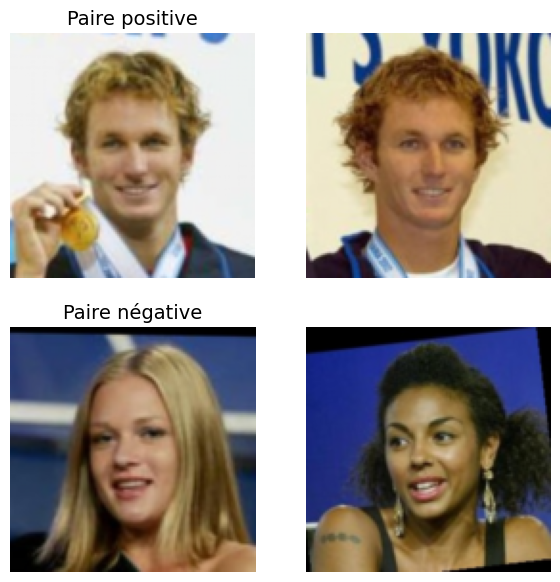

In [101]:
print('Nombre de paires pour le training: ',len(train_data))
print('Nombre de paires pour le test:',len(test_data))
print('Taille image',train_data[0][0].shape)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0, 0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0, 0].axis('off')

axs[0, 1].imshow(train_data[0][1].permute(1, 2, 0))
axs[0, 1].axis('off')
for data in train_data:
  if data[2]==0:
    axs[1, 0].imshow(data[0].permute(1,2,0))
    axs[1, 0].axis('off')
    axs[1, 1].imshow(data[1].permute(1,2,0))
    axs[1, 1].axis('off')
    break
axs[0, 0].set_title("Paire positive", fontsize=14, ha='center')
axs[1, 0].set_title("Paire négative", fontsize=14, ha='center');


Observamos que en el conjunto de datos, $Y=1$ corresponde a un par positivo mientras que $Y=0$ corresponde a un par negativo. Esto es lo opuesto a las notaciones del artículo. Vamos a invertir esto para mayor claridad.


In [102]:
# On ne peut pas modifier les données directement, on doit les transformer en listes
# Pour les données de training
train_data_list = [list(data) for data in train_data]
for data in train_data_list:
    data[2] = 1 - data[2]
train_data = [tuple(data) for data in train_data_list]

# Pour les données de test
test_data_list = [list(data) for data in test_data]
for data in test_data_list:
    data[2] = 1 - data[2]
test_data = [tuple(data) for data in test_data_list]

Ahora podremos crear nuestros *dataloaders*:


In [103]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Función de pérdida contrastiva


Es hora de definir nuestra función de pérdida. Para ello, simplemente retomaremos la fórmula que introdujimos anteriormente. Para $D_W$, tomamos la distancia euclidiana:
$D_W (X_1,X_2) = \lVert X_1 - X_2 \rVert_2 = \sqrt{\sum_{i=1}^{n} (X_{1,i} - X_{2,i})^2}$


In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Distance euclidienne entre les deux sorties du réseau
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Calcul du loss contrastif
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

### Creación de nuestro modelo


Para esta tarea, construiremos una red convolucional clásica y relativamente pequeña. El objetivo del modelo es proyectar los datos en un espacio donde la distancia euclidiana sea relevante.


In [142]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Extraction des features pertinentes
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Projection des features dans un espace de dimension réduite
        self.linear=nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 32), 
            )
    
    def forward(self, x1, x2):
        x1 = self.conv_net(x1)
        x2 = self.conv_net(x2)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x1=self.linear(x1)
        x2=self.linear(x2)
        return x1,x2

### Entrenamiento del modelo


Definamos nuestros hiperparámetros de entrenamiento:


In [134]:
epochs = 30
lr = 0.001
margin = 1.0
model = SiameseNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion=ContrastiveLoss(margin=margin)

In [135]:
for epoch in range(epochs):
  loss_train = 0
  for x1, x2, label in train_loader:
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    out1, out2 = model(x1, x2)
    loss = criterion(out1, out2, label)
    loss_train+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{epochs} Loss: {loss_train/len(train_loader)}")

Epoch 1/30 Loss: 0.4855058027998261
Epoch 2/30 Loss: 0.47506297098985617
Epoch 3/30 Loss: 0.44379603841166565
Epoch 4/30 Loss: 0.36472982092612033
Epoch 5/30 Loss: 0.31656959955243097
Epoch 6/30 Loss: 0.3091158025722573
Epoch 7/30 Loss: 0.2988005231903947
Epoch 8/30 Loss: 0.2873344306928524
Epoch 9/30 Loss: 0.28030256138763565
Epoch 10/30 Loss: 0.27428370077108993
Epoch 11/30 Loss: 0.27216234900381253
Epoch 12/30 Loss: 0.2714559338662935
Epoch 13/30 Loss: 0.2713507852260617
Epoch 14/30 Loss: 0.27069854628348694
Epoch 15/30 Loss: 0.26960040553324466
Epoch 16/30 Loss: 0.26909896256267163
Epoch 17/30 Loss: 0.2681442526155624
Epoch 18/30 Loss: 0.26780268636302673
Epoch 19/30 Loss: 0.2663887916267782
Epoch 20/30 Loss: 0.26515361407528754
Epoch 21/30 Loss: 0.26577359880658163
Epoch 22/30 Loss: 0.266544328543587
Epoch 23/30 Loss: 0.2644324919235879
Epoch 24/30 Loss: 0.26508791971465817
Epoch 25/30 Loss: 0.26529018699690915
Epoch 26/30 Loss: 0.26407808313767117
Epoch 27/30 Loss: 0.264637937796

### Evaluación del modelo


Ahora que el entrenamiento ha finalizado, es necesario evaluar el modelo. Pero, ¿cómo hacerlo? Este no es el tipo de modelo al que estamos acostumbrados a evaluar.

Tenemos nuestro conjunto de datos de prueba y podemos calcular las distancias entre cada par de este conjunto. De esta manera, podemos obtener una puntuación de similitud para cada elemento del conjunto de datos de prueba.

**La curva ROC**: La curva ROC (*Receiver Operating Characteristic*) es un gráfico que ilustra el rendimiento de un modelo de clasificación binaria (positivo o negativo en nuestro caso) a diferentes umbrales de decisión. La curva ROC contiene los siguientes elementos:
- **Eje X**: la tasa de falsos positivos (o tasa de falsas alarmas). Es el número de elementos negativos incorrectamente clasificados como positivos, dividido por el número total de elementos negativos.
- **Eje Y**: la tasa de verdaderos positivos (recall o sensibilidad). Es el número de elementos positivos correctamente clasificados como positivos, dividido por el número total de elementos positivos.

Cada punto de la curva representa un umbral de decisión diferente para la clasificación de los elementos.

![roc](./images/roc.png)

Figura extraída de [blogpost](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/).


Para juzgar la calidad de un modelo, podemos calcular el área bajo la curva ROC (AUROC). En el caso de un clasificador aleatorio, se obtiene un AUROC de 0.5, mientras que para un clasificador perfecto, el AUROC es de 1.

Podemos calcularlo para nuestro modelo:


In [139]:
from sklearn.metrics import roc_curve, auc

model.eval()
labels = []
distances = []
with torch.no_grad():
    for x1, x2, label in test_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        out1, out2 = model(x1, x2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        distances.extend(dist.cpu().numpy())
        labels.extend(label.cpu().numpy())
        
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.6163399999999999


Obtenemos un AUROC de aproximadamente 0.62, lo cual no es muy bueno. También podemos trazar la curva para ver cómo se ve.


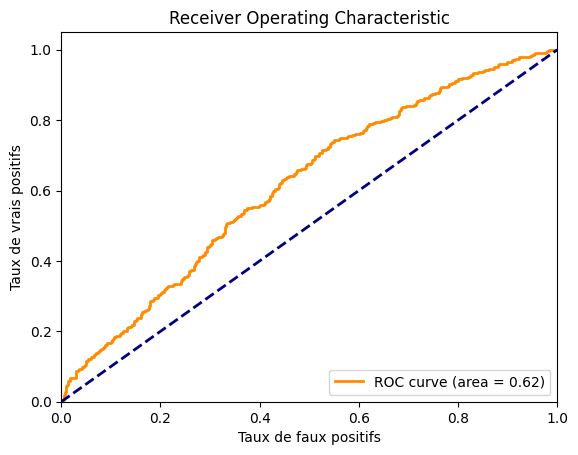

In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Observamos que el modelo no es muy eficiente. El conjunto de datos es probablemente demasiado complejo en comparación con el tamaño de nuestro modelo. Puedes intentar mejorar el rendimiento del modelo ajustando la arquitectura y los parámetros de entrenamiento.


## Pérdida por tripletes


### Reconocimiento facial


En el campo del procesamiento de rostros, existen dos categorías principales: la verificación facial y el reconocimiento facial.

Para entender la diferencia entre ambas, retomemos el caso de nuestro empleado en una empresa:
- **Verificación facial**: En el caso de la verificación facial, un empleado quiere entrar al edificio con su tarjeta de identificación. Pasa su tarjeta por la máquina, y el modelo de verificación facial verifica que se trata efectivamente del empleado que posee esa tarjeta.
- **Reconocimiento facial**: Aquí, debemos imaginar que el empleado se presenta al edificio sin su tarjeta y que el modelo es capaz de reconocerlo entre la base de datos de todos los empleados para permitirle la entrada al edificio.

Como pueden imaginar, la segunda tarea es más compleja, tanto en términos de dificultad pura como en términos de restricciones de tiempo de procesamiento (no podemos hacer esperar al empleado en la puerta durante una hora mientras comparamos su foto con las cientos de fotos de nuestra base de datos).


### FaceNet


Para la tarea de reconocimiento facial, un artículo [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832) introdujo un nuevo tipo de pérdida que se asemeja a la pérdida contrastiva. Se trata de la pérdida por tripletes, que describiremos brevemente.


El objetivo de esta pérdida es similar al de la pérdida contrastiva: busca aprender una representación de manera que los vectores de características (o *embeddings*) de puntos similares estén cercanos en el espacio latente, mientras que los de puntos diferentes estén alejados entre sí.

A diferencia de la pérdida contrastiva, que se basa en pares de ejemplos, la pérdida por tripletes se basa en tripletes de ejemplos.

Cada ejemplo tiene un rol particular:
- **Anchor (A)**: El ejemplo de referencia del cual queremos aprender una representación.
- **Positive (P)**: Un ejemplo similar al *anchor* (por ejemplo, la misma persona).
- **Negative (N)**: Un ejemplo diferente al *anchor* (una persona diferente).

La función de pérdida se define de la siguiente manera:
$L_{\text{triplet}} = \max\left( d(A, P) - d(A, N) + \alpha, 0 \right)$ donde $d$ es la distancia y $\alpha$ el margen (*margin*).

Esta pérdida minimiza la distancia entre $P$ y $A$ mientras maximiza la distancia entre $N$ y $A$.

![tripletloss](./images/tripletloss.png)

Figura extraída del artículo original.

Esto puede parecer redundante con la pérdida contrastiva, y en parte lo es. Sin embargo, la pérdida por tripletes ha demostrado mejores resultados cuando se trata de hacer una distinción fina entre clases bastante similares (típicamente el caso del reconocimiento facial). Hoy en día, su uso es preferido sobre la pérdida contrastiva para tareas de procesamiento de rostros.